## DGP with three groups

This file provides a demonstration of the DGP

In [5]:
import numpy as np
import cvxpy as cp
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns


In [6]:

# set parameters
N = 30
K = 3
T2 = 200


### The Core Part

In [7]:

# the "core" part of L2-relaxation. Three groups
Sigma = np.matrix([[1, 1, 0], [1, 2, 0], [0, 0, 2] ])
Sigma_inv = np.linalg.inv(Sigma)
# w uses the exact formula of Bates-Granger solution
w_core = (Sigma_inv @ np.ones((K,1))) / (np.ones((1,K)) @ Sigma_inv @ np.ones((K,1)))
w_core

matrix([[0.66666667],
        [0.        ],
        [0.33333333]])

Notice that the 2nd element of the above solution is 0. Therefore, sparsity is welcomed.

The optimal weight of this problem can be solved by hand. 
Anyway, the following block uses "CVXPY" to solve it automatically.
```
w = cp.Variable(K)
objective = cp.Minimize(cp.quad_form(w, Sigma))
constraints = [cp.sum(w) == 1]
prob = cp.Problem(objective, constraints)

result = prob.solve()
print(w.value)
```
This block demonstrate the Bates-Granger solution in case `Sigma` is non-invertible

### Full Scale Oracle Model

Now we extend the core part (3 groups) into the full scale model (N individuals). Each group has `N_k = N/K` people. `big_Sigma` is N-by-N equicorrelation matrix, and `w_true` is N-by-1 vector of the oracle weight. (In our L2-relaxation paper, "Oracle" means no idiosyncratic errors.)

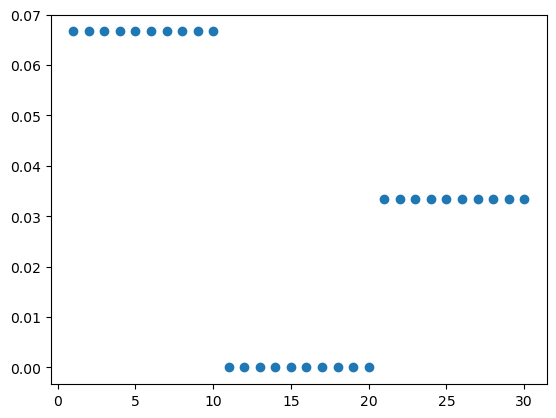

In [8]:
N_k = np.int8(N/K)
big_Sigma = np.kron( Sigma, np.ones([N_k, N_k]) ) 
w_true = np.repeat( w_core * (K/N), N_k ).reshape(N, -1) 

plt.plot(np.arange(N)+1, w_true, 'o') # plot the true value

`half_Sigma` is the (matrix) square root of `big_Sigma`

In [9]:
_, S, V = np.linalg.svd(big_Sigma)
half_Sigma  = np.diag(np.sqrt(S)) @ V

`FF_true` is a T2-by-N matrix. Each column represnts the true signal that an expert receives about a macro variable `Y` (to be defined soon). `var(FF_true) = big_Sigma`. `FF_true` is unobservable to the researcher.

In [10]:
FF_true = np.random.randn(T2, N) @ half_Sigma  

In reality, the researcher observes `Y`, which is a liner combination of the true signal with the true weight *plus a random noise*.

Each column of `FF` is the observed (by the researcher) prediction from an expert. The expert has a noise `noise_factor * np.random.randn(T2,N)` to perturb it from the true signal. `noise_factor` is to be used to control the signal-to-noise level.

In [11]:
Y = np.dot(FF_true,  w_true )  + 0.5 * np.random.randn(T2,1)

noise_factor = 0.5
FF = FF_true + noise_factor * np.random.randn(T2,N) @ np.eye(N)


Compute the signal-to-noise ratio in this given DGP, where the signal is evaluated at the oracle weights. 
In our preliminary experiments, let's try relatively strong SNR, say 2~3.

In [12]:
R_sq = 1 - np.var(Y - np.dot(FF, w_true)) / np.var(Y)
SNR = R_sq / (1-R_sq) # signal-to-noise ratio
print(SNR)

2.6921879181499575


### Feasible Weight Estimation

Below is what a researcher does in reality. He observes the data in which the signal is contaminated by noises.

In [13]:
EE = Y - FF # individual prediction error
big_Sigma_hat = EE.T @ EE / N # covariance matrix of prediction errors


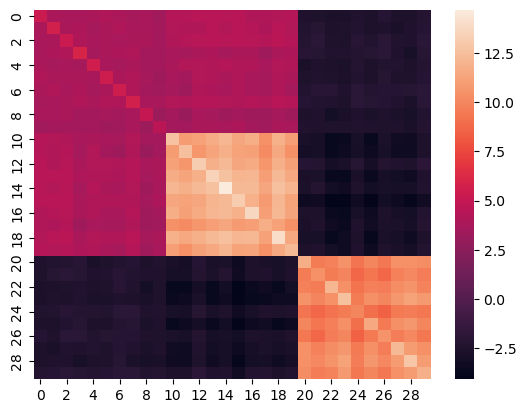

In [14]:

sns.heatmap(big_Sigma_hat, annot=False)
plt.show()

In the above heatmap, we can clearly see three groups with small noises.

Let us try the Bates-Granger solution.

[[ 0.02948571 -0.014371   -0.0612495   0.00402105  0.06838129  0.10285354
   0.04817391 -0.06753521  0.21802271  0.2633604   0.06352138  0.0939832
  -0.12497272 -0.04529866 -0.06074524  0.03908322  0.05423068  0.06363655
  -0.05872194  0.03057945  0.03799589  0.11839881  0.05346701  0.01475254
   0.16179665  0.07815178  0.06089822 -0.03775709 -0.01347099 -0.12067164]]


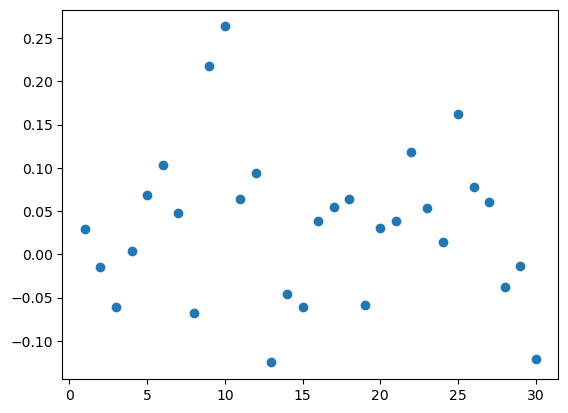

In [21]:
# compare with the explicit solution
w_hat_BG_exact = ( np.linalg.inv(big_Sigma_hat) @ np.ones(N) ) / ( np.ones(N).T @ np.linalg.inv(big_Sigma_hat) @ np.ones(N) )
print(w_hat_BG_exact)
plt.plot(np.r_[1:(N+1)], w_hat_BG_exact.T, 'o')

Given T2 = 200 and N = 30, the BG solution is very unsatisfactory. We observe no patterns.

#### L2-relaxation

In [16]:
tau = 0.3 # the tuning parameter in L2-relaxation

w_g = cp.Variable(N + 1)

w = w_g[:N]
gam = w_g[N]

objective = cp.Minimize(cp.norm2(w))
constraints = [cp.sum(w) == 1,
               big_Sigma_hat @ w - gam <= tau,
               big_Sigma_hat @ w - gam >= -tau]
prob = cp.Problem(objective, constraints)

result = prob.solve()

[ 0.05674926  0.0613744   0.05794857  0.0623027   0.05963614  0.05857611
  0.05954575  0.06014072  0.0606001   0.07215337  0.00690851  0.01070362
 -0.008521    0.00369294 -0.00100182  0.00931232  0.002308    0.00908066
  0.00383683  0.00798756  0.03325721  0.03406379  0.03882473  0.0357724
  0.03478996  0.03953254  0.03443769  0.03427501  0.03169958  0.03001233]


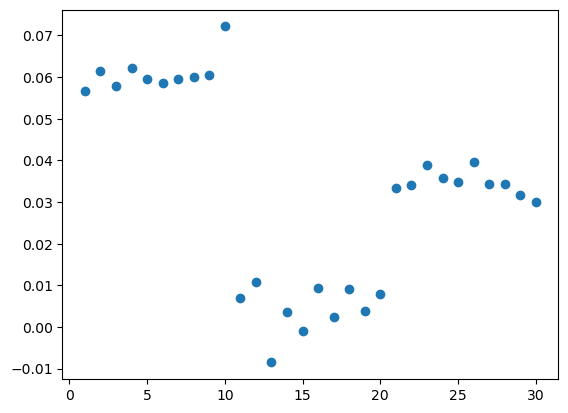

In [17]:
w_hat_L2r = w.value[:N]
print(w_hat_L2r)
plt.plot(np.r_[1:(N+1)], w_hat_L2r, 'o')

We can roughly observe three groups in the above graph.